In [163]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

import matplotlib.pyplot as plt
import psycopg2
import numpy as np
import sklearn
import requests
import scipy

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
conn = psycopg2.connect(database="delay", user="nikita")
conn.autocommit = True

In [3]:
line, way = 95, 2

cur = conn.cursor()
cur.execute("SELECT * FROM traject WHERE line='%i' AND way=%i ORDER BY id;" % (line, way))
data = cur.fetchall()

In [9]:
from collections import namedtuple
Traject = namedtuple("Traject", ('id', 'line', 'way', 'timestamps', 'start'))
models = [Traject(*row) for row in data]

In [19]:
stib_stops = requests.get("https://stib-mivb-api.herokuapp.com/network/line/%s/%s" % (line, way)).json()['stops']
len_stops = len(max(models, key=lambda x: len(x.timestamps)).timestamps)
assert len(stib_stops) == len_stops

In [66]:
vectors = []
for model in models:
    vector = [np.nan] * (len_stops - 1)
    
    for i in range(len_stops - 1):
        try:
            vector[i] = (model.timestamps[i + 1] - model.timestamps[i]).total_seconds()
        except (IndexError, TypeError):
            vector[i] = np.nan
    vectors.append(vector)

vectors = np.array(vectors)

In [70]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values="NaN", strategy='mean', axis=0)
imputed_vectors = imputer.fit_transform(vectors)

# Split the vectors in 2: features are v[:12] and targets are v[12:]
X, Y = imputed_vectors[:,:12], imputed_vectors[:,12:]

from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [77]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=130, n_jobs=-1).fit(X_train, Y_train)

In [183]:
predictions = knn.predict(X_test)

# Score d'une prédiction
Il y a plusieurs méthodes pour scorer une prédiction et j'aimerais voir les différences entres ces méthodes

In [172]:
def score_distance(diff):
    return np.linalg.norm(diff)

def score_weight_more_first(diff):
    start, stop = 1, 0.2
    weights = np.arange(start, stop, -(start-stop)/len(diff))
    return np.linalg.norm(diff * weights)

def score_one_on_n(diff):
    weights = 1/ np.arange(1, len(diff) + 1)
    return np.linalg.norm(diff * weights)

def score_distance_double_negative(diff):
    for i, val in enumerate(diff):
        if val < 0:
            diff[i] = -val * 2
    return np.linalg.norm(diff) 

distances_fn = [score_distance, score_weight_more_first, score_one_on_n, score_distance_double_negative]

distances = {}
diff = Y_test - predictions

for fn in distances_fn:
    distances[fn.__name__] = np.apply_along_axis(fn, 1, diff)

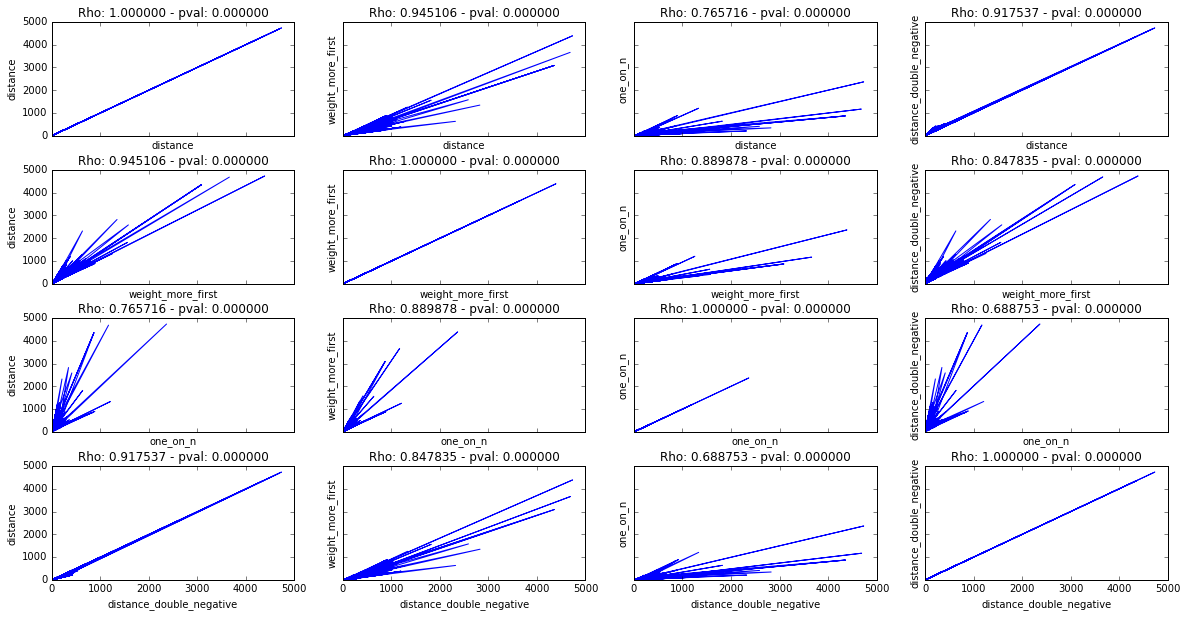

In [182]:
fig, ax =  plt.subplots(len(distances_fn), len(distances_fn), sharex='all', sharey='all')
plt.subplots_adjust(hspace = 0.3)

for i, first in enumerate(distances_fn):
    for j, second in enumerate(distances_fn):
        p = ax[i][j]
        p.plot(distances[first.__name__], distances[second.__name__])
        rho, pval = scipy.stats.spearmanr(distances[first.__name__], distances[second.__name__])
        p.set_title("Rho: %f - pval: %f" % (rho, pval))
        p.axes.set_xlabel(first.__name__[6:])
        p.axes.set_ylabel(second.__name__[6:])

# Score d'un modèle
Pour choisir les hyper-paramètres qui caractérisent un modèle, il faut pouvoir le scorer pour pouvoir comparer deux modèles entre eux

In [285]:
def model_mean(errors):
    return np.mean(errors)

def model_median(errors):
    return np.median(errors)

def model_worst(errors):
    return np.max(errors) / 50

model_score_fn = [model_mean, model_median, model_worst]

k_list = range(1, 5000, 50)
model_scores = {fn.__name__: [] for fn in model_score_fn}

for k in k_list:
    knn = KNeighborsRegressor(n_neighbors=k, n_jobs=-1).fit(X_train, Y_train)
    predictions = knn.predict(X_test)
    
    diff = Y_test - predictions
    predictions_scores = np.apply_along_axis(score_distance, 1, diff)
    for fn in model_score_fn:
        model_scores[fn.__name__].append(fn(predictions_scores))

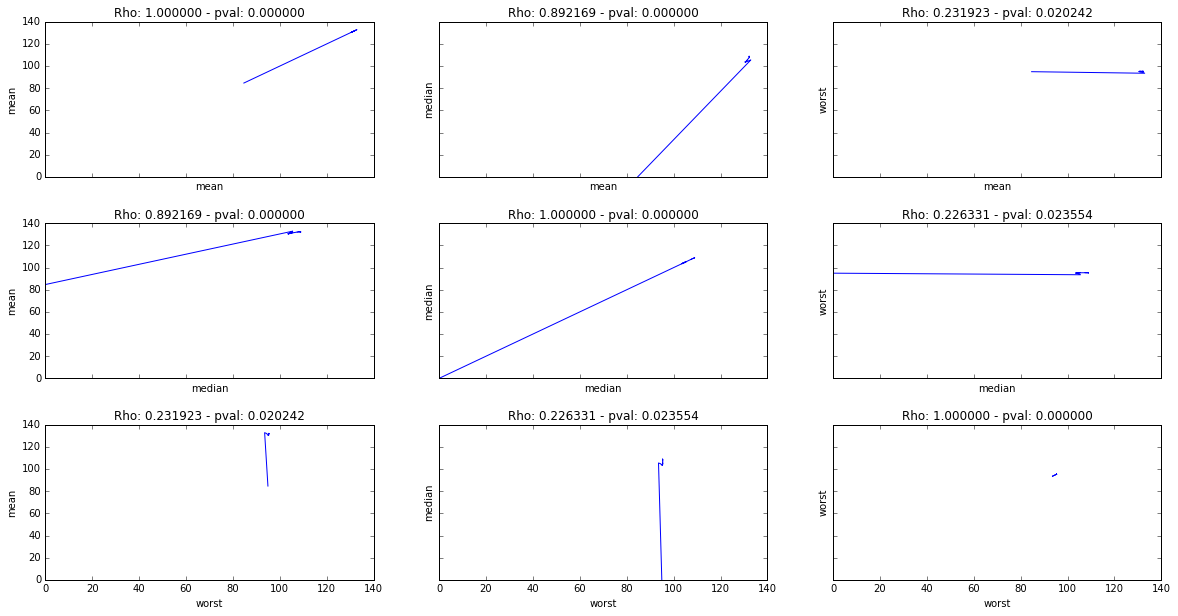

In [286]:
fig, ax =  plt.subplots(len(model_score_fn), len(model_score_fn), sharex='all', sharey='all')
plt.subplots_adjust(hspace = 0.3)

for i, first in enumerate(model_score_fn):
    for j, second in enumerate(model_score_fn):
        p = ax[i][j]
        p.plot(model_scores[first.__name__], model_scores[second.__name__])
        rho, pval = scipy.stats.spearmanr(model_scores[first.__name__], model_scores[second.__name__])
        p.set_title("Rho: %f - pval: %f" % (rho, pval))
        p.axes.set_xlabel(first.__name__[6:])
        p.axes.set_ylabel(second.__name__[6:])
        

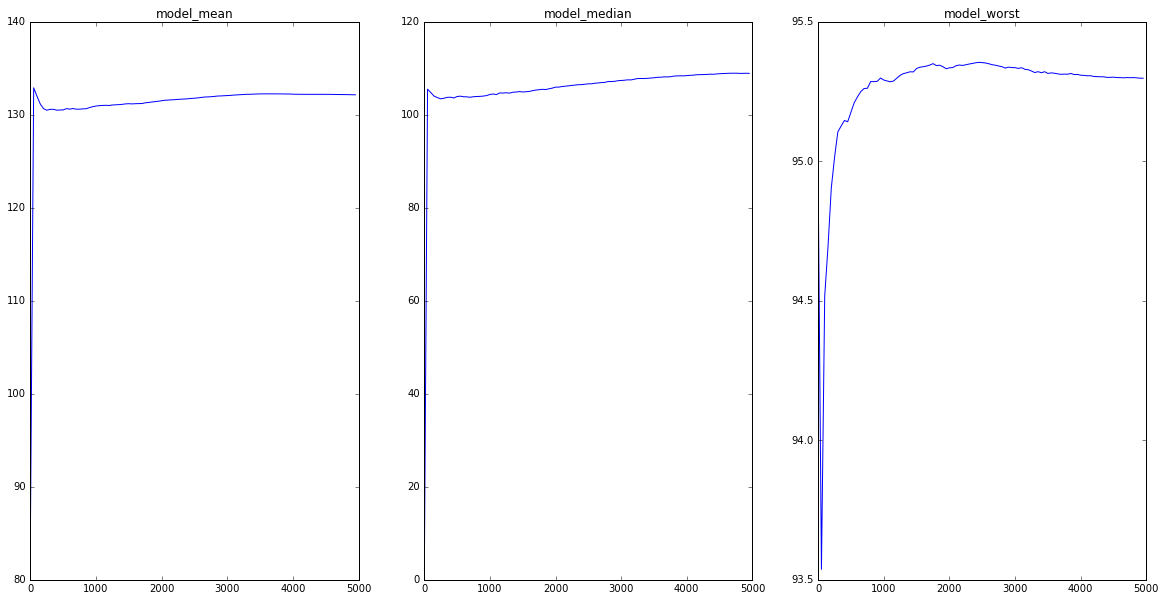

In [287]:
fig, axs = plt.subplots(1,len(model_scores))
for i, fn in enumerate(model_score_fn):
    axs[i].plot(k_list, model_scores[fn.__name__])
    axs[i].set_title(fn.__name__)
    p.axes.set_xlabel("k")
    p.axes.set_ylabel("mean score")

In [288]:
print("Best k:", k_list[model_scores['model_mean'].index(min(model_scores['model_mean']))])


Best k: 1


In [282]:
def score_k(k):
    knn = KNeighborsRegressor(n_neighbors=int(k), n_jobs=-1).fit(X_train, Y_train)
    predictions = knn.predict(X_test)
    
    diff = Y_test - predictions
    predictions_scores = np.apply_along_axis(score_distance, 1, diff)
    return model_mean(predictions_scores)


opts = {'maxiter': 20, 'disp': True, 'xatol': 0.1}
res = scipy.optimize.minimize_scalar(score_k, bounds=(1, 1000), method='bounded', options=opts)
print("Best k:", int(res.x))
print(res)

Best k: 430
     fun: 130.48902421879845
 message: 'Solution found.'
    nfev: 15
  status: 0
 success: True
       x: 430.38221006087684


In [289]:
opts = {'maxiter': 20, 'disp': True, 'xatol': 0.1}
res = scipy.optimize.minimize_scalar(score_k, bounds=(1, 10), method='bounded', options=opts)
print("Best k:", int(res.x))
print(res)

Best k: 3
     fun: 138.73528625369042
 message: 'Solution found.'
    nfev: 8
  status: 0
 success: True
       x: 3.1843451943676535
